In [1]:
import sys
sys.path.append('../') # or just install the module
sys.path.append('../../flaming-choripan') # or just install the module
sys.path.append('../../astro-lightcurves-handler') # or just install the module

==============================linear-fstw
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


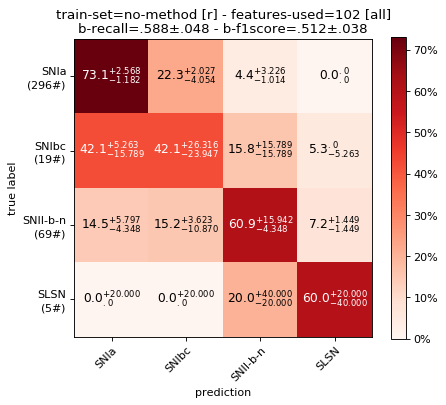

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


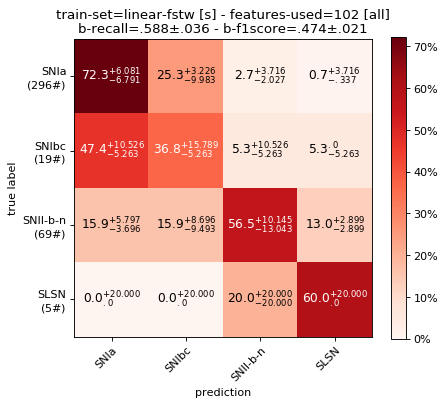

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


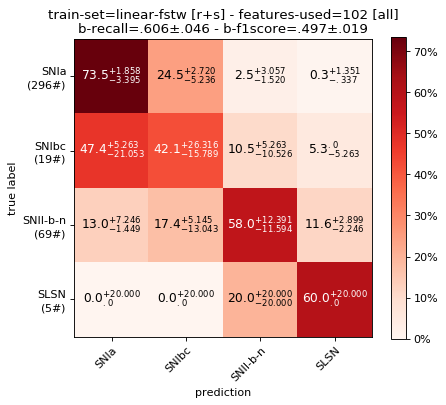

==============================bspline-fstw
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


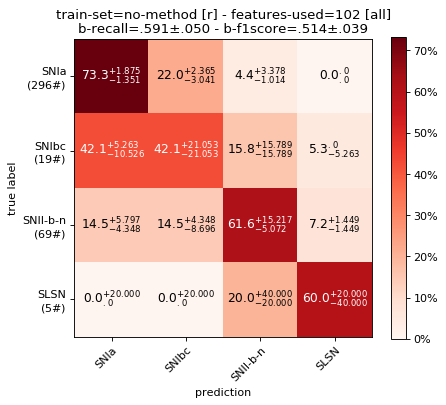

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


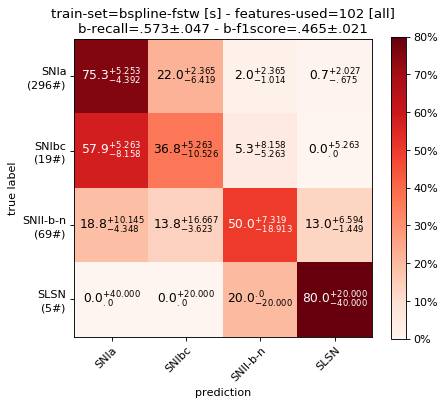

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


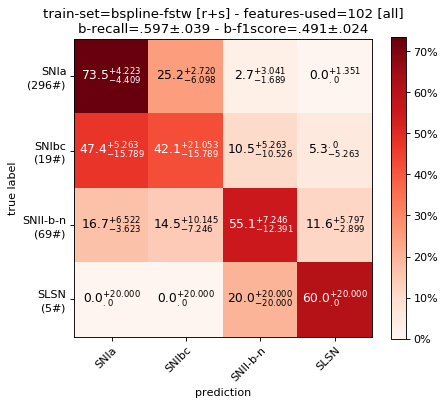

==============================spm-mcmc-fstw
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


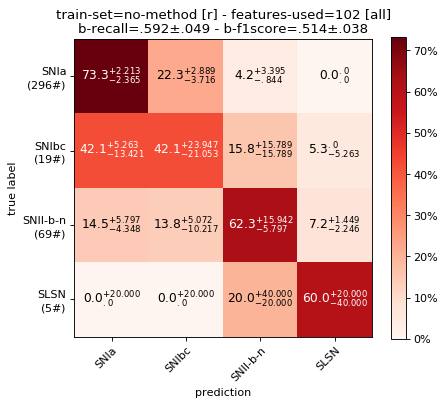

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


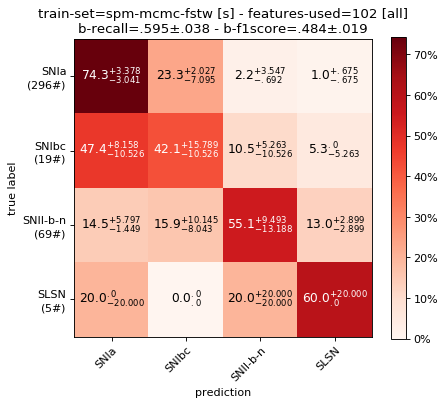

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


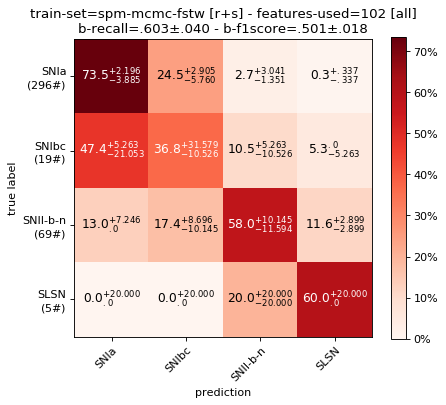

==============================spm-mcmc-estw
Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


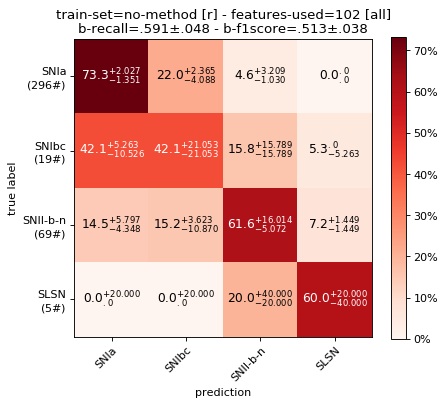

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


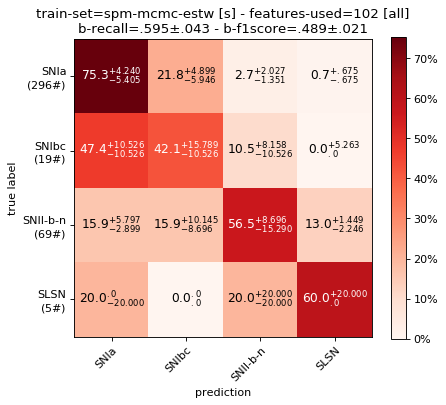

Confusion matrix. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)


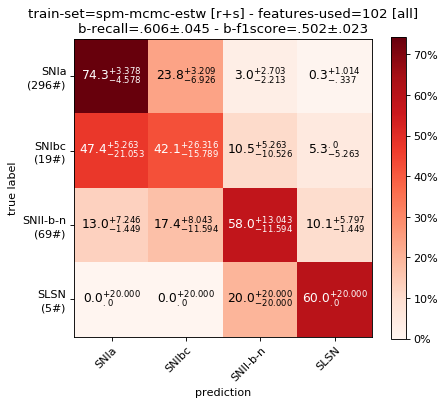

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import search_for_filedirs, gather_files_by_kfold
from flamingchoripan.cuteplots.cm_plots import plot_custom_confusion_matrix
import matplotlib.pyplot as plt
from flamingchoripan.datascience.xerror import XError
from IPython.display import display

def get_kf_text(set_name, kf):
    if kf=='.':
        return f'($\\mu\\pm\\sigma$ from 5-fold cross-validation in {set_name}-set)'
    else:
        return f'($\\mu\\pm\\sigma$ from {kf} k-fold in {set_name}-set)'

def get_mode_text(mode, features):
    if mode=='sne':
        return f'Using {len(features)} SNe selected astrophysical features [{mode}]'
    else:
        return f'Using {len(features)} astrophysical features [{mode}]'
    
mode = 'all' # all sne
methods = [
    'linear-fstw',
    'bspline-fstw',
    #'spm-mle-fstw',
    'spm-mcmc-fstw',
    #'spm-mle-estw',
    'spm-mcmc-estw',
]
#methods = ['spm-mcmc-estw']
eval_lcset_name = 'test'
kf = '.'

for method in methods:
    print('='*30+method)
    for train_config in ['r', 's', 'r+s']:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        features = files[0]()['features']
        cms = np.concatenate([f()['cm'][None] for f in files], axis=0)
        bprecision_xe = XError([f()['metrics_dict']['b-precision'] for f in files])
        brecall_xe = XError([f()['metrics_dict']['b-recall'] for f in files])
        bf1score_xe = XError([f()['metrics_dict']['b-f1score'] for f in files])

        ### plot cm
        _title = 'no-method [r]' if train_config=='r' else f'{method} [{train_config}]'
        title = ''
        title += f'train-set={_title} - features-used={len(features)} [{mode}]'+'\n'
        #title += f'train-set={_title} - eval-set={kf}@{eval_lcset_name}'+'\n'
        #title += f'b-p/r={bprecision_xe} / {brecall_xe}'+'\n'
        #title += f'b-f1score={bf1score_xe}'+'\n'
        title += f'b-recall={brecall_xe} - b-f1score={bf1score_xe}'+'\n'
        cm_kwargs = {
            'title':title[:-1],
            'figsize':(6,5),
            'new_order_classes':['SNIa', 'SNIbc', 'SNII-b-n', 'SLSN'],
        }
        fig, ax, cm_norm = plot_custom_confusion_matrix(cms, class_names, **cm_kwargs)
        #accu = XError(np.diagonal(cm_norm*100, axis1=1, axis2=2).flatten().tolist())
        #title += f'b-accu={accu}'+'\n'
        #ax.set_title(title[:-1])
        caption = ''
        caption += f'Confusion matrix.'
        caption += f' {get_mode_text(mode, features)} {get_kf_text(eval_lcset_name, kf)}'
        print(caption)
        plt.show()

In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

dmetrics = {
    f'b-precision':{'k':1, 'mn':None},
    f'b-recall':{'k':1, 'mn':None},
    f'b-f1score':{'k':1, 'mn':None},
    f'b-rocauc':{'k':1, 'mn':'b-AUCROC'},
    #f'b-prauc':{'k':1, 'mn':'b-AUCPR'},
    }
info_df = DFBuilder()
for train_config in ['r', 's', 'r+s']:
    aux_r = []
    for method in methods:
        d = {}
        for metric in dmetrics.keys():
            mn = metric if dmetrics[metric]['mn'] is None else dmetrics[metric]['mn']
            rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
            files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
            class_names = files[0]()['lcset_info']['class_names']
            features = files[0]()['features']
            metric_xe = XError([f()['metrics_dict'][metric]*dmetrics[metric]['k'] for f in files])
            d[mn] = metric_xe
            #print(len(metric_xe))
        
        if not train_config=='r': # mean across methods in real case
            info_df.append(f'synthetic-method={method} [{train_config}]', d)
        else:
            aux_r.append(d)

    if train_config=='r': # mean across methods in real case
        for r in aux_r:
            print(r)
        new_d = {k:sum([r[k] for r in aux_r]) for k in d.keys()}
        info_df.append(f'synthetic-method=no-method [{train_config}]', new_d)
    
#save_pickle(f'baseline{mode}', info_df())
display(info_df())
caption = ''
caption += f'Synthetic generation methods scores using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s].'
caption += f' {get_mode_text(mode, features)} {get_kf_text(eval_lcset_name, kf)}'

latex_kwargs = {
    'caption':caption,
    'label':'?',
    #'bold_axis':'columns',
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'b-precision': .511±.026, 'b-recall': .588±.048, 'b-f1score': .512±.038, 'b-AUCROC': .814±.031}
{'b-precision': .512±.028, 'b-recall': .591±.050, 'b-f1score': .514±.039, 'b-AUCROC': .814±.031}
{'b-precision': .513±.028, 'b-recall': .592±.049, 'b-f1score': .514±.038, 'b-AUCROC': .814±.030}
{'b-precision': .510±.027, 'b-recall': .591±.048, 'b-f1score': .513±.038, 'b-AUCROC': .814±.031}


,b-precision,b-recall,b-f1score,b-AUCROC
synthetic-method=no-method [r],.512±.027,.591±.049,.513±.038,.814±.031
synthetic-method=linear-fstw [s],.496±.024,.588±.036,.474±.021,.811±.023
synthetic-method=bspline-fstw [s],.494±.020,.573±.047,.465±.021,.799±.029
synthetic-method=spm-mcmc-fstw [s],.500±.016,.595±.038,.484±.019,.815±.021
synthetic-method=spm-mcmc-estw [s],.504±.019,.595±.043,.489±.021,.814±.023
synthetic-method=linear-fstw [r+s],.512±.024,.606±.046,.497±.019,.818±.028
synthetic-method=bspline-fstw [r+s],.509±.029,.597±.039,.491±.024,.813±.031
synthetic-method=spm-mcmc-fstw [r+s],.513±.024,.603±.040,.501±.018,.821±.026
synthetic-method=spm-mcmc-estw [r+s],.514±.027,.606±.045,.502±.023,.820±.027


%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Synthetic generation methods scores using only real samples [r], only synthetic samples [s], and the same proportion of real and synthetic samples [r+s]. Using 102 astrophysical features ($\mu\pm\sigma$ from 5-fold cross-validation in test-set)}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc}
\hline
synthetic-method & b-precision & b-recall & b-f1score & b-AUCROC \srule\\\hline\hline
no-method [r] & .512$\pm$.027 & .591$\pm$.049 & .513$\pm$.038 & .814$\pm$.031  \srule\\
linear-fstw [s] & .496$\pm$.024 & .588$\pm$.036 & .474$\pm$.021 & .811$\pm$.023  \srule\\
bspline-fstw [s] & .494$\pm$.020 & .573$\pm$.047 & .465$\pm$.021 & .799$\pm$.029  \srule\\
spm-mcmc-fstw [s] & .500$\pm$.016 & .595$\pm$.038 & .484$\pm$.019 & .815$\pm$.021  \srule\\
spm-mcmc-estw [s] & .504$\pm$.019 & .595$\pm$.043 & .489$\pm$.021 & 

In [4]:
%load_ext autoreload
%autoreload 2
import numpy as np
from flamingchoripan.files import load_pickle, save_pickle
from flamingchoripan.datascience.xerror import XError
from flamingchoripan.dataframes import DFBuilder
from flamingchoripan.latex.latex_tables import LatexTable

info_df = DFBuilder()
train_config = 'r+s' # r s r+s
rank_n = 10
for k in range(0, rank_n):
    d = {}
    for method in methods:
        rootdir = f'../save/exp=rf_eval~train_config={train_config}~mode={mode}/survey=alerceZTFv7.1~bands=gr~mode=onlySNe~method={method}'
        files, files_ids = gather_files_by_kfold(rootdir, kf, eval_lcset_name)
        class_names = files[0]()['lcset_info']['class_names']
        features = files[0]()['features']
        rank = files[0]()['rank'] # just show one
        feature_name, feature_p,_ = rank[k]
        feature_name = feature_name.replace('_', '-')
        d[f'{method} [{train_config}]'] = f'{feature_name} ({feature_p*100:.2f}%)'

    info_df.append(f'k={k+1}', d)

caption = ''
caption += f'Random Forest astrophysical features ranking (top {rank_n}) using the same proportion of real and synthetic samples [r+s].'
caption += f' {get_mode_text(mode, features)}.'

latex_kwargs = {
    'caption':caption,
    'label':'?',
    #'custom_tabular_align':'l|'+'c'*sum([m.split('-')[-1]=='fstw' for m in methods])+'|'+'c'*sum([m.split('-')[-1]=='estw' for m in methods]),
}
latex_table = LatexTable(info_df(), **latex_kwargs)
print(latex_table)
info_df()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
\def\srule{\rule{0pt}{2ex}\rule[-1ex]{0pt}{0ex}}
\begin{table*}
\centering
\caption{Random Forest astrophysical features ranking (top 10) using the same proportion of real and synthetic samples [r+s]. Using 102 astrophysical features.}
\label{?}\vspace{.1cm}
\begin{tabular}{l|cccc}
\hline
k & linear-fstw [r+s] & bspline-fstw [r+s] & spm-mcmc-fstw [r+s] & spm-mcmc-estw [r+s] \srule\\\hline\hline
1 & SPM-t0-g (12.12\%) & SPM-t0-g (9.89\%) & SPM-t0-g (12.58\%) & SPM-t0-g (10.21\%)  \srule\\
2 & SPM-t0-r (8.53\%) & LinearTrend-g (9.53\%) & LinearTrend-g (7.85\%) & LinearTrend-g (8.13\%)  \srule\\
3 & LinearTrend-g (7.62\%) & SPM-t0-r (7.41\%) & SPM-t0-r (7.54\%) & SPM-t0-r (8.13\%)  \srule\\
4 & LinearTrend-r (6.72\%) & LinearTrend-r (6.49\%) & SPM-gamma-r (6.32\%) & SPM-gamma-r (6.47\%)  \srule\\
5 & SP

,linear-fstw [r+s],bspline-fstw [r+s],spm-mcmc-fstw [r+s],spm-mcmc-estw [r+s]
k=1,SPM-t0-g (12.12%),SPM-t0-g (9.89%),SPM-t0-g (12.58%),SPM-t0-g (10.21%)
k=2,SPM-t0-r (8.53%),LinearTrend-g (9.53%),LinearTrend-g (7.85%),LinearTrend-g (8.13%)
k=3,LinearTrend-g (7.62%),SPM-t0-r (7.41%),SPM-t0-r (7.54%),SPM-t0-r (8.13%)
k=4,LinearTrend-r (6.72%),LinearTrend-r (6.49%),SPM-gamma-r (6.32%),SPM-gamma-r (6.47%)
k=5,SPM-gamma-r (5.91%),SPM-gamma-r (5.56%),LinearTrend-r (5.79%),LinearTrend-r (5.63%)
k=6,ExcessVar-r (3.95%),SPM-gamma-g (5.09%),Meanvariance-r (4.54%),PairSlopeTrend-g (3.89%)
k=7,Meanvariance-r (3.74%),Meanvariance-r (4.67%),SPM-tau-rise-r (4.10%),SPM-gamma-g (3.79%)
k=8,PairSlopeTrend-g (3.17%),ExcessVar-r (4.00%),SPM-gamma-g (4.04%),SPM-tau-rise-r (3.77%)
k=9,SPM-gamma-g (3.11%),PairSlopeTrend-g (3.03%),ExcessVar-r (3.50%),Meanvariance-r (3.74%)
k=10,SPM-tau-rise-r (3.05%),SPM-tau-rise-r (2.98%),PairSlopeTrend-g (2.87%),ExcessVar-r (3.12%)
